In [1]:
import sys
sys.path.append("../code/")
from common import APPLIANCES_ORDER


In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tensor = np.load('../1H-input.npy')

In [4]:
def create_subset_dataset(tensor):
    t_subset = tensor[:, :, 180:194, :]
    all_indices = np.array(list(range(320)))
    for i in range(1, 7):
        valid_homes = pd.DataFrame(t_subset[:, i, :].reshape(320, 14*24)).dropna().index
        all_indices = np.intersect1d(all_indices, valid_homes)
    t_subset = t_subset[all_indices, :, :, :].reshape(52, 7, 14, 24)
    
    # Create artificial aggregate
    t_subset[:, 0, :,:] = 0.0
    for i in range(1, 7):
        t_subset[:, 0, :,:] = t_subset[:, 0, :,:] + t_subset[:, i, :,:]
    # t_subset is of shape (#home, appliance, days*hours)
    return t_subset, all_indices

In [5]:
t_all, valid_homes = create_subset_dataset(tensor)
t_all.shape

(52, 7, 14, 24)

In [6]:
t_all.shape

(52, 7, 14, 24)

In [7]:
def my_objective(y_pred, y_true):
    with tf.name_scope(None):
        return tf.losses.absolute_difference(y_pred, y_true)

In [8]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Conv1D, Dense, Flatten, MaxPool1D, InputLayer, Activation, Dropout, MaxPooling1D


import keras
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
n_movies = 3
n_users=3
n_latent_factors=2

Using TensorFlow backend.
/Users/nipun/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [9]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

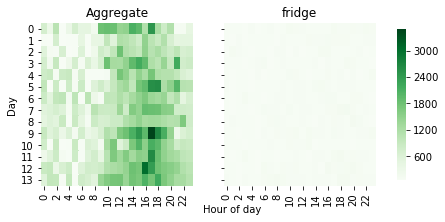

In [10]:
import seaborn as sns
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(6,3))
cbar_ax = fig.add_axes([.95, 0.15, .02, .7])
home = 4
appliance_num = 2
sns.heatmap(t_all[home, 0, :, :],cmap='Greens',ax=ax[0],cbar_ax=None,cbar=False)
sns.heatmap(t_all[home, appliance_num, :, :],cmap='Greens',ax=ax[1],cbar_ax=cbar_ax,vmax=t_all[home, 0, :, :].max())
ax[0].set_title("Aggregate")
ax[1].set_title(APPLIANCES_ORDER[appliance_num])
ax[0].set_ylabel("Day")
fig.text(0.5, 0, "Hour of day")


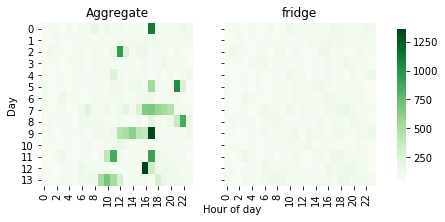

In [11]:
import seaborn as sns
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(6,3))
cbar_ax = fig.add_axes([.95, 0.15, .02, .7])
home = 4
appliance_num = 2
sns.heatmap(t_all[home, 0, :, :]-t_all[home, 1, :, :],cmap='Greens',ax=ax[0],cbar_ax=None,cbar=False)
sns.heatmap(t_all[home, appliance_num, :, :],cmap='Greens',ax=ax[1],cbar_ax=cbar_ax,vmax=(t_all[home, 0, :, :]-t_all[home, 1, :, :]).max())
ax[0].set_title("Aggregate")
ax[1].set_title(APPLIANCES_ORDER[appliance_num])
ax[0].set_ylabel("Day")
fig.text(0.5, 0, "Hour of day")

In [12]:
num_days = 14
num_hours = 24

In [13]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(num_days, num_hours, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(4, (14, 1), activation='relu', padding='same')(input_img)
#x = Conv2D(10, (1, 2), activation='relu', padding='same')(input_img)


#x = MaxPooling2D((1, 2), padding='same')(x)
#x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
#x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

#x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#x = UpSampling2D((2, 2))(x)
#x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#x = UpSampling2D((2, 2))(x)
#x = Conv2D(16, (3, 3), activation='relu',padding='same')(x)
#x = UpSampling2D((1, 2))(x)
decoded = Conv2D(1, (1,24), activation='relu', padding='same')(x)

autoencoder = Model(input_img, decoded)
from keras.optimizers import Adam


In [14]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 14, 24, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 24, 4)         60        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 24, 1)         97        
Total params: 157
Trainable params: 157
Non-trainable params: 0
_________________________________________________________________


In [15]:
autoencoder = Model(input_img, decoded)
appliance_num=2
print(APPLIANCES_ORDER[appliance_num])

fridge


In [16]:
maxs = {appliance_num:t_all[:30, appliance_num, :, :].max() for appliance_num in range(7)}

In [17]:
maxs

{0: 5000.416633605957,
 1: 3963.88330078125,
 2: 288.85000610351562,
 3: 960.7833251953125,
 4: 1122.300048828125,
 5: 498.43331909179688,
 6: 2914.800048828125}

In [18]:
autoencoder.compile(optimizer='adam', loss='mean_absolute_error')
autoencoder.fit(((t_all[:30, 0, :, :]-t_all[:30, 1, :, :]).reshape(-1, num_days, num_hours,1)/maxs[0]),(t_all[:30, appliance_num, :, :].reshape(-1, num_days, num_hours,1) /maxs[appliance_num])
                ,validation_split=0.1,epochs=1500)

Train on 27 samples, validate on 3 samples
Epoch 1/1500
27/27 [==============================] - 0s 7ms/step - loss: 0.2908 - val_loss: 0.3183
Epoch 2/1500
27/27 [==============================] - 0s 314us/step - loss: 0.2881 - val_loss: 0.3153
Epoch 3/1500
27/27 [==============================] - 0s 561us/step - loss: 0.2851 - val_loss: 0.3121
Epoch 4/1500
27/27 [==============================] - 0s 380us/step - loss: 0.2820 - val_loss: 0.3088
Epoch 5/1500
27/27 [==============================] - 0s 391us/step - loss: 0.2788 - val_loss: 0.3054
Epoch 6/1500
27/27 [==============================] - 0s 404us/step - loss: 0.2755 - val_loss: 0.3018
Epoch 7/1500
27/27 [==============================] - 0s 410us/step - loss: 0.2720 - val_loss: 0.2981
Epoch 8/1500
27/27 [==============================] - 0s 369us/step - loss: 0.2684 - val_loss: 0.2943
Epoch 9/1500
27/27 [==============================] - 0s 326us/step - loss: 0.2648 - val_loss: 0.2903
Epoch 10/1500
27/27 [====================

Epoch 81/1500
27/27 [==============================] - 0s 412us/step - loss: 0.0973 - val_loss: 0.1208
Epoch 82/1500
27/27 [==============================] - 0s 414us/step - loss: 0.0973 - val_loss: 0.1206
Epoch 83/1500
27/27 [==============================] - 0s 447us/step - loss: 0.0972 - val_loss: 0.1205
Epoch 84/1500
27/27 [==============================] - 0s 385us/step - loss: 0.0972 - val_loss: 0.1203
Epoch 85/1500
27/27 [==============================] - 0s 416us/step - loss: 0.0971 - val_loss: 0.1201
Epoch 86/1500
27/27 [==============================] - 0s 406us/step - loss: 0.0971 - val_loss: 0.1199
Epoch 87/1500
27/27 [==============================] - 0s 368us/step - loss: 0.0970 - val_loss: 0.1197
Epoch 88/1500
27/27 [==============================] - 0s 341us/step - loss: 0.0969 - val_loss: 0.1194
Epoch 89/1500
27/27 [==============================] - 0s 381us/step - loss: 0.0969 - val_loss: 0.1192
Epoch 90/1500
27/27 [==============================] - 0s 396us/step - lo

Epoch 160/1500
27/27 [==============================] - 0s 417us/step - loss: 0.0948 - val_loss: 0.1162
Epoch 161/1500
27/27 [==============================] - 0s 408us/step - loss: 0.0948 - val_loss: 0.1161
Epoch 162/1500
27/27 [==============================] - 0s 352us/step - loss: 0.0948 - val_loss: 0.1161
Epoch 163/1500
27/27 [==============================] - 0s 376us/step - loss: 0.0947 - val_loss: 0.1160
Epoch 164/1500
27/27 [==============================] - 0s 389us/step - loss: 0.0947 - val_loss: 0.1160
Epoch 165/1500
27/27 [==============================] - 0s 371us/step - loss: 0.0947 - val_loss: 0.1160
Epoch 166/1500
27/27 [==============================] - 0s 359us/step - loss: 0.0947 - val_loss: 0.1159
Epoch 167/1500
27/27 [==============================] - 0s 383us/step - loss: 0.0946 - val_loss: 0.1159
Epoch 168/1500
27/27 [==============================] - 0s 383us/step - loss: 0.0946 - val_loss: 0.1159
Epoch 169/1500
27/27 [==============================] - 0s 366us

Epoch 239/1500
27/27 [==============================] - 0s 348us/step - loss: 0.0919 - val_loss: 0.1110
Epoch 240/1500
27/27 [==============================] - 0s 339us/step - loss: 0.0919 - val_loss: 0.1109
Epoch 241/1500
27/27 [==============================] - 0s 322us/step - loss: 0.0918 - val_loss: 0.1108
Epoch 242/1500
27/27 [==============================] - 0s 330us/step - loss: 0.0918 - val_loss: 0.1107
Epoch 243/1500
27/27 [==============================] - 0s 368us/step - loss: 0.0917 - val_loss: 0.1105
Epoch 244/1500
27/27 [==============================] - 0s 351us/step - loss: 0.0917 - val_loss: 0.1104
Epoch 245/1500
27/27 [==============================] - 0s 295us/step - loss: 0.0916 - val_loss: 0.1103
Epoch 246/1500
27/27 [==============================] - 0s 315us/step - loss: 0.0916 - val_loss: 0.1102
Epoch 247/1500
27/27 [==============================] - 0s 318us/step - loss: 0.0916 - val_loss: 0.1101
Epoch 248/1500
27/27 [==============================] - 0s 331us

Epoch 318/1500
27/27 [==============================] - 0s 402us/step - loss: 0.0884 - val_loss: 0.1030
Epoch 319/1500
27/27 [==============================] - 0s 467us/step - loss: 0.0883 - val_loss: 0.1029
Epoch 320/1500
27/27 [==============================] - 0s 423us/step - loss: 0.0883 - val_loss: 0.1029
Epoch 321/1500
27/27 [==============================] - 0s 439us/step - loss: 0.0883 - val_loss: 0.1028
Epoch 322/1500
27/27 [==============================] - 0s 559us/step - loss: 0.0882 - val_loss: 0.1028
Epoch 323/1500
27/27 [==============================] - 0s 427us/step - loss: 0.0882 - val_loss: 0.1027
Epoch 324/1500
27/27 [==============================] - 0s 560us/step - loss: 0.0881 - val_loss: 0.1026
Epoch 325/1500
27/27 [==============================] - 0s 1ms/step - loss: 0.0881 - val_loss: 0.1026
Epoch 326/1500
27/27 [==============================] - 0s 757us/step - loss: 0.0881 - val_loss: 0.1025
Epoch 327/1500
27/27 [==============================] - 0s 466us/s

Epoch 397/1500
27/27 [==============================] - 0s 420us/step - loss: 0.0853 - val_loss: 0.0967
Epoch 398/1500
27/27 [==============================] - 0s 405us/step - loss: 0.0853 - val_loss: 0.0967
Epoch 399/1500
27/27 [==============================] - 0s 334us/step - loss: 0.0853 - val_loss: 0.0967
Epoch 400/1500
27/27 [==============================] - 0s 319us/step - loss: 0.0852 - val_loss: 0.0966
Epoch 401/1500
27/27 [==============================] - 0s 344us/step - loss: 0.0852 - val_loss: 0.0966
Epoch 402/1500
27/27 [==============================] - 0s 320us/step - loss: 0.0852 - val_loss: 0.0966
Epoch 403/1500
27/27 [==============================] - 0s 410us/step - loss: 0.0851 - val_loss: 0.0965
Epoch 404/1500
27/27 [==============================] - 0s 408us/step - loss: 0.0851 - val_loss: 0.0965
Epoch 405/1500
27/27 [==============================] - 0s 447us/step - loss: 0.0851 - val_loss: 0.0965
Epoch 406/1500
27/27 [==============================] - 0s 296us

Epoch 476/1500
27/27 [==============================] - 0s 405us/step - loss: 0.0832 - val_loss: 0.0945
Epoch 477/1500
27/27 [==============================] - 0s 408us/step - loss: 0.0831 - val_loss: 0.0944
Epoch 478/1500
27/27 [==============================] - 0s 370us/step - loss: 0.0831 - val_loss: 0.0944
Epoch 479/1500
27/27 [==============================] - 0s 416us/step - loss: 0.0831 - val_loss: 0.0945
Epoch 480/1500
27/27 [==============================] - 0s 297us/step - loss: 0.0831 - val_loss: 0.0943
Epoch 481/1500
27/27 [==============================] - 0s 335us/step - loss: 0.0831 - val_loss: 0.0944
Epoch 482/1500
27/27 [==============================] - 0s 420us/step - loss: 0.0830 - val_loss: 0.0945
Epoch 483/1500
27/27 [==============================] - 0s 482us/step - loss: 0.0830 - val_loss: 0.0942
Epoch 484/1500
27/27 [==============================] - 0s 344us/step - loss: 0.0830 - val_loss: 0.0943
Epoch 485/1500
27/27 [==============================] - 0s 333us

Epoch 555/1500
27/27 [==============================] - 0s 315us/step - loss: 0.0820 - val_loss: 0.0933
Epoch 556/1500
27/27 [==============================] - 0s 327us/step - loss: 0.0820 - val_loss: 0.0931
Epoch 557/1500
27/27 [==============================] - 0s 346us/step - loss: 0.0820 - val_loss: 0.0932
Epoch 558/1500
27/27 [==============================] - 0s 335us/step - loss: 0.0820 - val_loss: 0.0933
Epoch 559/1500
27/27 [==============================] - 0s 350us/step - loss: 0.0820 - val_loss: 0.0931
Epoch 560/1500
27/27 [==============================] - 0s 296us/step - loss: 0.0820 - val_loss: 0.0932
Epoch 561/1500
27/27 [==============================] - 0s 375us/step - loss: 0.0820 - val_loss: 0.0932
Epoch 562/1500
27/27 [==============================] - 0s 396us/step - loss: 0.0820 - val_loss: 0.0931
Epoch 563/1500
27/27 [==============================] - 0s 333us/step - loss: 0.0820 - val_loss: 0.0931
Epoch 564/1500
27/27 [==============================] - 0s 385us

Epoch 634/1500
27/27 [==============================] - 0s 360us/step - loss: 0.0815 - val_loss: 0.0926
Epoch 635/1500
27/27 [==============================] - 0s 315us/step - loss: 0.0815 - val_loss: 0.0925
Epoch 636/1500
27/27 [==============================] - 0s 292us/step - loss: 0.0815 - val_loss: 0.0926
Epoch 637/1500
27/27 [==============================] - 0s 333us/step - loss: 0.0815 - val_loss: 0.0926
Epoch 638/1500
27/27 [==============================] - 0s 345us/step - loss: 0.0815 - val_loss: 0.0925
Epoch 639/1500
27/27 [==============================] - 0s 387us/step - loss: 0.0815 - val_loss: 0.0925
Epoch 640/1500
27/27 [==============================] - 0s 344us/step - loss: 0.0815 - val_loss: 0.0926
Epoch 641/1500
27/27 [==============================] - 0s 320us/step - loss: 0.0815 - val_loss: 0.0925
Epoch 642/1500
27/27 [==============================] - 0s 342us/step - loss: 0.0815 - val_loss: 0.0925
Epoch 643/1500
27/27 [==============================] - 0s 358us

Epoch 713/1500
27/27 [==============================] - 0s 360us/step - loss: 0.0811 - val_loss: 0.0923
Epoch 714/1500
27/27 [==============================] - 0s 299us/step - loss: 0.0811 - val_loss: 0.0923
Epoch 715/1500
27/27 [==============================] - 0s 304us/step - loss: 0.0811 - val_loss: 0.0922
Epoch 716/1500
27/27 [==============================] - 0s 303us/step - loss: 0.0811 - val_loss: 0.0923
Epoch 717/1500
27/27 [==============================] - 0s 311us/step - loss: 0.0811 - val_loss: 0.0923
Epoch 718/1500
27/27 [==============================] - 0s 318us/step - loss: 0.0811 - val_loss: 0.0922
Epoch 719/1500
27/27 [==============================] - 0s 305us/step - loss: 0.0811 - val_loss: 0.0922
Epoch 720/1500
27/27 [==============================] - 0s 301us/step - loss: 0.0811 - val_loss: 0.0923
Epoch 721/1500
27/27 [==============================] - 0s 362us/step - loss: 0.0811 - val_loss: 0.0923
Epoch 722/1500
27/27 [==============================] - 0s 335us

Epoch 792/1500
27/27 [==============================] - 0s 338us/step - loss: 0.0808 - val_loss: 0.0919
Epoch 793/1500
27/27 [==============================] - 0s 352us/step - loss: 0.0808 - val_loss: 0.0919
Epoch 794/1500
27/27 [==============================] - 0s 363us/step - loss: 0.0808 - val_loss: 0.0918
Epoch 795/1500
27/27 [==============================] - 0s 319us/step - loss: 0.0808 - val_loss: 0.0919
Epoch 796/1500
27/27 [==============================] - 0s 372us/step - loss: 0.0808 - val_loss: 0.0918
Epoch 797/1500
27/27 [==============================] - 0s 347us/step - loss: 0.0808 - val_loss: 0.0918
Epoch 798/1500
27/27 [==============================] - 0s 331us/step - loss: 0.0808 - val_loss: 0.0918
Epoch 799/1500
27/27 [==============================] - 0s 349us/step - loss: 0.0807 - val_loss: 0.0918
Epoch 800/1500
27/27 [==============================] - 0s 355us/step - loss: 0.0807 - val_loss: 0.0918
Epoch 801/1500
27/27 [==============================] - 0s 341us

Epoch 871/1500
27/27 [==============================] - 0s 365us/step - loss: 0.0805 - val_loss: 0.0915
Epoch 872/1500
27/27 [==============================] - 0s 388us/step - loss: 0.0805 - val_loss: 0.0915
Epoch 873/1500
27/27 [==============================] - 0s 361us/step - loss: 0.0805 - val_loss: 0.0915
Epoch 874/1500
27/27 [==============================] - 0s 334us/step - loss: 0.0805 - val_loss: 0.0915
Epoch 875/1500
27/27 [==============================] - 0s 332us/step - loss: 0.0805 - val_loss: 0.0915
Epoch 876/1500
27/27 [==============================] - 0s 344us/step - loss: 0.0805 - val_loss: 0.0915
Epoch 877/1500
27/27 [==============================] - 0s 373us/step - loss: 0.0805 - val_loss: 0.0915
Epoch 878/1500
27/27 [==============================] - 0s 329us/step - loss: 0.0805 - val_loss: 0.0915
Epoch 879/1500
27/27 [==============================] - 0s 336us/step - loss: 0.0805 - val_loss: 0.0915
Epoch 880/1500
27/27 [==============================] - 0s 347us

Epoch 950/1500
27/27 [==============================] - 0s 486us/step - loss: 0.0803 - val_loss: 0.0912
Epoch 951/1500
27/27 [==============================] - 0s 339us/step - loss: 0.0803 - val_loss: 0.0912
Epoch 952/1500
27/27 [==============================] - 0s 344us/step - loss: 0.0802 - val_loss: 0.0912
Epoch 953/1500
27/27 [==============================] - 0s 315us/step - loss: 0.0802 - val_loss: 0.0912
Epoch 954/1500
27/27 [==============================] - 0s 298us/step - loss: 0.0802 - val_loss: 0.0912
Epoch 955/1500
27/27 [==============================] - 0s 374us/step - loss: 0.0802 - val_loss: 0.0912
Epoch 956/1500
27/27 [==============================] - 0s 298us/step - loss: 0.0802 - val_loss: 0.0912
Epoch 957/1500
27/27 [==============================] - 0s 322us/step - loss: 0.0802 - val_loss: 0.0912
Epoch 958/1500
27/27 [==============================] - 0s 318us/step - loss: 0.0802 - val_loss: 0.0912
Epoch 959/1500
27/27 [==============================] - 0s 336us

Epoch 1029/1500
27/27 [==============================] - 0s 460us/step - loss: 0.0800 - val_loss: 0.0910
Epoch 1030/1500
27/27 [==============================] - 0s 419us/step - loss: 0.0800 - val_loss: 0.0910
Epoch 1031/1500
27/27 [==============================] - 0s 409us/step - loss: 0.0800 - val_loss: 0.0910
Epoch 1032/1500
27/27 [==============================] - 0s 427us/step - loss: 0.0800 - val_loss: 0.0910
Epoch 1033/1500
27/27 [==============================] - 0s 575us/step - loss: 0.0800 - val_loss: 0.0910
Epoch 1034/1500
27/27 [==============================] - 0s 523us/step - loss: 0.0800 - val_loss: 0.0910
Epoch 1035/1500
27/27 [==============================] - 0s 489us/step - loss: 0.0800 - val_loss: 0.0910
Epoch 1036/1500
27/27 [==============================] - 0s 536us/step - loss: 0.0800 - val_loss: 0.0910
Epoch 1037/1500
27/27 [==============================] - 0s 401us/step - loss: 0.0800 - val_loss: 0.0909
Epoch 1038/1500
27/27 [==============================] 

27/27 [==============================] - 0s 336us/step - loss: 0.0798 - val_loss: 0.0907
Epoch 1108/1500
27/27 [==============================] - 0s 366us/step - loss: 0.0798 - val_loss: 0.0908
Epoch 1109/1500
27/27 [==============================] - 0s 381us/step - loss: 0.0798 - val_loss: 0.0907
Epoch 1110/1500
27/27 [==============================] - 0s 479us/step - loss: 0.0798 - val_loss: 0.0908
Epoch 1111/1500
27/27 [==============================] - 0s 416us/step - loss: 0.0798 - val_loss: 0.0907
Epoch 1112/1500
27/27 [==============================] - 0s 417us/step - loss: 0.0798 - val_loss: 0.0907
Epoch 1113/1500
27/27 [==============================] - 0s 441us/step - loss: 0.0798 - val_loss: 0.0907
Epoch 1114/1500
27/27 [==============================] - 0s 478us/step - loss: 0.0798 - val_loss: 0.0907
Epoch 1115/1500
27/27 [==============================] - 0s 413us/step - loss: 0.0798 - val_loss: 0.0907
Epoch 1116/1500
27/27 [==============================] - 0s 467us/step 

Epoch 1186/1500
27/27 [==============================] - 0s 380us/step - loss: 0.0797 - val_loss: 0.0904
Epoch 1187/1500
27/27 [==============================] - 0s 401us/step - loss: 0.0797 - val_loss: 0.0904
Epoch 1188/1500
27/27 [==============================] - 0s 387us/step - loss: 0.0797 - val_loss: 0.0904
Epoch 1189/1500
27/27 [==============================] - 0s 336us/step - loss: 0.0797 - val_loss: 0.0904
Epoch 1190/1500
27/27 [==============================] - 0s 320us/step - loss: 0.0797 - val_loss: 0.0904
Epoch 1191/1500
27/27 [==============================] - 0s 314us/step - loss: 0.0797 - val_loss: 0.0904
Epoch 1192/1500
27/27 [==============================] - 0s 354us/step - loss: 0.0797 - val_loss: 0.0904
Epoch 1193/1500
27/27 [==============================] - 0s 282us/step - loss: 0.0797 - val_loss: 0.0904
Epoch 1194/1500
27/27 [==============================] - 0s 335us/step - loss: 0.0796 - val_loss: 0.0904
Epoch 1195/1500
27/27 [==============================] 

27/27 [==============================] - 0s 330us/step - loss: 0.0795 - val_loss: 0.0902
Epoch 1265/1500
27/27 [==============================] - 0s 343us/step - loss: 0.0795 - val_loss: 0.0902
Epoch 1266/1500
27/27 [==============================] - 0s 392us/step - loss: 0.0795 - val_loss: 0.0902
Epoch 1267/1500
27/27 [==============================] - 0s 414us/step - loss: 0.0795 - val_loss: 0.0902
Epoch 1268/1500
27/27 [==============================] - 0s 401us/step - loss: 0.0795 - val_loss: 0.0902
Epoch 1269/1500
27/27 [==============================] - 0s 395us/step - loss: 0.0795 - val_loss: 0.0902
Epoch 1270/1500
27/27 [==============================] - 0s 377us/step - loss: 0.0795 - val_loss: 0.0902
Epoch 1271/1500
27/27 [==============================] - 0s 438us/step - loss: 0.0795 - val_loss: 0.0902
Epoch 1272/1500
27/27 [==============================] - 0s 430us/step - loss: 0.0795 - val_loss: 0.0902
Epoch 1273/1500
27/27 [==============================] - 0s 408us/step 

Epoch 1343/1500
27/27 [==============================] - 0s 383us/step - loss: 0.0793 - val_loss: 0.0901
Epoch 1344/1500
27/27 [==============================] - 0s 336us/step - loss: 0.0793 - val_loss: 0.0901
Epoch 1345/1500
27/27 [==============================] - 0s 459us/step - loss: 0.0793 - val_loss: 0.0902
Epoch 1346/1500
27/27 [==============================] - 0s 405us/step - loss: 0.0793 - val_loss: 0.0901
Epoch 1347/1500
27/27 [==============================] - 0s 444us/step - loss: 0.0793 - val_loss: 0.0901
Epoch 1348/1500
27/27 [==============================] - 0s 340us/step - loss: 0.0793 - val_loss: 0.0902
Epoch 1349/1500
27/27 [==============================] - 0s 373us/step - loss: 0.0793 - val_loss: 0.0901
Epoch 1350/1500
27/27 [==============================] - 0s 419us/step - loss: 0.0793 - val_loss: 0.0901
Epoch 1351/1500
27/27 [==============================] - 0s 356us/step - loss: 0.0793 - val_loss: 0.0902
Epoch 1352/1500
27/27 [==============================] 

Epoch 1421/1500
27/27 [==============================] - 0s 364us/step - loss: 0.0791 - val_loss: 0.0902
Epoch 1422/1500
27/27 [==============================] - 0s 333us/step - loss: 0.0791 - val_loss: 0.0902
Epoch 1423/1500
27/27 [==============================] - 0s 356us/step - loss: 0.0791 - val_loss: 0.0902
Epoch 1424/1500
27/27 [==============================] - 0s 318us/step - loss: 0.0791 - val_loss: 0.0902
Epoch 1425/1500
27/27 [==============================] - 0s 360us/step - loss: 0.0791 - val_loss: 0.0903
Epoch 1426/1500
27/27 [==============================] - 0s 326us/step - loss: 0.0791 - val_loss: 0.0902
Epoch 1427/1500
27/27 [==============================] - 0s 338us/step - loss: 0.0790 - val_loss: 0.0903
Epoch 1428/1500
27/27 [==============================] - 0s 355us/step - loss: 0.0790 - val_loss: 0.0903
Epoch 1429/1500
27/27 [==============================] - 0s 337us/step - loss: 0.0790 - val_loss: 0.0903
Epoch 1430/1500
27/27 [==============================] 

Epoch 1500/1500
27/27 [==============================] - 0s 364us/step - loss: 0.0788 - val_loss: 0.0905


In [19]:
pred = maxs[appliance_num]*autoencoder.predict((t_all[30:, 0, :, :]-t_all[30:, 1, :, :]).reshape(-1, num_days, num_hours,1)/maxs[0]).reshape(-1, num_days, num_hours)
gt =t_all[30:, appliance_num, :, :]


pred_fl = pred.flatten()
gt_fl = gt.flatten()

In [20]:
pred.shape, (t_all[:30, 0, :, :].reshape(-1, num_days, num_hours,1)/maxs[0]).shape

((22, 14, 24), (30, 14, 24, 1))

In [23]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(gt_fl, pred_fl)

19.172464696846166

Train on 27 samples, validate on 3 samples
Epoch 1/1500
27/27 [==============================] - 0s 6ms/step - loss: 0.0533 - val_loss: 0.0446
Epoch 2/1500
27/27 [==============================] - 0s 384us/step - loss: 0.0415 - val_loss: 0.0355
Epoch 3/1500
27/27 [==============================] - 0s 502us/step - loss: 0.0326 - val_loss: 0.0282
Epoch 4/1500
27/27 [==============================] - 0s 422us/step - loss: 0.0259 - val_loss: 0.0228
Epoch 5/1500
27/27 [==============================] - 0s 441us/step - loss: 0.0211 - val_loss: 0.0190
Epoch 6/1500
27/27 [==============================] - 0s 367us/step - loss: 0.0179 - val_loss: 0.0165
Epoch 7/1500
27/27 [==============================] - 0s 443us/step - loss: 0.0156 - val_loss: 0.0146
Epoch 8/1500
27/27 [==============================] - 0s 423us/step - loss: 0.0139 - val_loss: 0.0133
Epoch 9/1500
27/27 [==============================] - 0s 402us/step - loss: 0.0127 - val_loss: 0.0124
Epoch 10/1500
27/27 [====================

Epoch 81/1500
27/27 [==============================] - 0s 457us/step - loss: 0.0101 - val_loss: 0.0109
Epoch 82/1500
27/27 [==============================] - 0s 441us/step - loss: 0.0101 - val_loss: 0.0109
Epoch 83/1500
27/27 [==============================] - 0s 463us/step - loss: 0.0101 - val_loss: 0.0109
Epoch 84/1500
27/27 [==============================] - 0s 439us/step - loss: 0.0101 - val_loss: 0.0108
Epoch 85/1500
27/27 [==============================] - 0s 445us/step - loss: 0.0101 - val_loss: 0.0108
Epoch 86/1500
27/27 [==============================] - 0s 412us/step - loss: 0.0101 - val_loss: 0.0108
Epoch 87/1500
27/27 [==============================] - 0s 442us/step - loss: 0.0101 - val_loss: 0.0108
Epoch 88/1500
27/27 [==============================] - 0s 384us/step - loss: 0.0101 - val_loss: 0.0108
Epoch 89/1500
27/27 [==============================] - 0s 388us/step - loss: 0.0101 - val_loss: 0.0108
Epoch 90/1500
27/27 [==============================] - 0s 399us/step - lo

Epoch 160/1500
27/27 [==============================] - 0s 405us/step - loss: 0.0099 - val_loss: 0.0106
Epoch 161/1500
27/27 [==============================] - 0s 495us/step - loss: 0.0099 - val_loss: 0.0106
Epoch 162/1500
27/27 [==============================] - 0s 412us/step - loss: 0.0099 - val_loss: 0.0106
Epoch 163/1500
27/27 [==============================] - 0s 378us/step - loss: 0.0099 - val_loss: 0.0106
Epoch 164/1500
27/27 [==============================] - 0s 409us/step - loss: 0.0099 - val_loss: 0.0106
Epoch 165/1500
27/27 [==============================] - 0s 486us/step - loss: 0.0099 - val_loss: 0.0106
Epoch 166/1500
27/27 [==============================] - 0s 480us/step - loss: 0.0099 - val_loss: 0.0106
Epoch 167/1500
27/27 [==============================] - 0s 496us/step - loss: 0.0099 - val_loss: 0.0106
Epoch 168/1500
27/27 [==============================] - 0s 425us/step - loss: 0.0099 - val_loss: 0.0106
Epoch 169/1500
27/27 [==============================] - 0s 430us

Epoch 239/1500
27/27 [==============================] - 0s 421us/step - loss: 0.0097 - val_loss: 0.0105
Epoch 240/1500
27/27 [==============================] - 0s 437us/step - loss: 0.0097 - val_loss: 0.0105
Epoch 241/1500
27/27 [==============================] - 0s 420us/step - loss: 0.0097 - val_loss: 0.0105
Epoch 242/1500
27/27 [==============================] - 0s 397us/step - loss: 0.0097 - val_loss: 0.0105
Epoch 243/1500
27/27 [==============================] - 0s 417us/step - loss: 0.0097 - val_loss: 0.0105
Epoch 244/1500
27/27 [==============================] - 0s 404us/step - loss: 0.0097 - val_loss: 0.0105
Epoch 245/1500
27/27 [==============================] - 0s 412us/step - loss: 0.0097 - val_loss: 0.0105
Epoch 246/1500
27/27 [==============================] - 0s 389us/step - loss: 0.0097 - val_loss: 0.0105
Epoch 247/1500
27/27 [==============================] - 0s 391us/step - loss: 0.0097 - val_loss: 0.0105
Epoch 248/1500
27/27 [==============================] - 0s 437us

Epoch 318/1500
27/27 [==============================] - 0s 431us/step - loss: 0.0096 - val_loss: 0.0104
Epoch 319/1500
27/27 [==============================] - 0s 447us/step - loss: 0.0096 - val_loss: 0.0104
Epoch 320/1500
27/27 [==============================] - 0s 391us/step - loss: 0.0096 - val_loss: 0.0104
Epoch 321/1500
27/27 [==============================] - 0s 345us/step - loss: 0.0096 - val_loss: 0.0104
Epoch 322/1500
27/27 [==============================] - 0s 539us/step - loss: 0.0096 - val_loss: 0.0104
Epoch 323/1500
27/27 [==============================] - 0s 430us/step - loss: 0.0095 - val_loss: 0.0104
Epoch 324/1500
27/27 [==============================] - 0s 386us/step - loss: 0.0095 - val_loss: 0.0104
Epoch 325/1500
27/27 [==============================] - 0s 416us/step - loss: 0.0095 - val_loss: 0.0104
Epoch 326/1500
27/27 [==============================] - 0s 445us/step - loss: 0.0095 - val_loss: 0.0104
Epoch 327/1500
27/27 [==============================] - 0s 353us

Epoch 397/1500
27/27 [==============================] - 0s 423us/step - loss: 0.0094 - val_loss: 0.0102
Epoch 398/1500
27/27 [==============================] - 0s 456us/step - loss: 0.0094 - val_loss: 0.0102
Epoch 399/1500
27/27 [==============================] - 0s 454us/step - loss: 0.0094 - val_loss: 0.0102
Epoch 400/1500
27/27 [==============================] - 0s 360us/step - loss: 0.0094 - val_loss: 0.0102
Epoch 401/1500
27/27 [==============================] - 0s 403us/step - loss: 0.0094 - val_loss: 0.0102
Epoch 402/1500
27/27 [==============================] - 0s 391us/step - loss: 0.0094 - val_loss: 0.0102
Epoch 403/1500
27/27 [==============================] - 0s 403us/step - loss: 0.0094 - val_loss: 0.0102
Epoch 404/1500
27/27 [==============================] - 0s 408us/step - loss: 0.0094 - val_loss: 0.0102
Epoch 405/1500
27/27 [==============================] - 0s 439us/step - loss: 0.0094 - val_loss: 0.0102
Epoch 406/1500
27/27 [==============================] - 0s 434us

Epoch 476/1500
27/27 [==============================] - 0s 417us/step - loss: 0.0092 - val_loss: 0.0101
Epoch 477/1500
27/27 [==============================] - 0s 436us/step - loss: 0.0092 - val_loss: 0.0101
Epoch 478/1500
27/27 [==============================] - 0s 405us/step - loss: 0.0092 - val_loss: 0.0101
Epoch 479/1500
27/27 [==============================] - 0s 415us/step - loss: 0.0092 - val_loss: 0.0101
Epoch 480/1500
27/27 [==============================] - 0s 427us/step - loss: 0.0092 - val_loss: 0.0101
Epoch 481/1500
27/27 [==============================] - 0s 499us/step - loss: 0.0092 - val_loss: 0.0101
Epoch 482/1500
27/27 [==============================] - 0s 471us/step - loss: 0.0092 - val_loss: 0.0101
Epoch 483/1500
27/27 [==============================] - 0s 470us/step - loss: 0.0092 - val_loss: 0.0101
Epoch 484/1500
27/27 [==============================] - 0s 400us/step - loss: 0.0092 - val_loss: 0.0101
Epoch 485/1500
27/27 [==============================] - 0s 386us

Epoch 555/1500
27/27 [==============================] - 0s 480us/step - loss: 0.0090 - val_loss: 0.0099
Epoch 556/1500
27/27 [==============================] - 0s 422us/step - loss: 0.0090 - val_loss: 0.0099
Epoch 557/1500
27/27 [==============================] - 0s 382us/step - loss: 0.0090 - val_loss: 0.0099
Epoch 558/1500
27/27 [==============================] - 0s 407us/step - loss: 0.0090 - val_loss: 0.0099
Epoch 559/1500
27/27 [==============================] - 0s 408us/step - loss: 0.0090 - val_loss: 0.0099
Epoch 560/1500
27/27 [==============================] - 0s 490us/step - loss: 0.0090 - val_loss: 0.0099
Epoch 561/1500
27/27 [==============================] - 0s 386us/step - loss: 0.0090 - val_loss: 0.0099
Epoch 562/1500
27/27 [==============================] - 0s 277us/step - loss: 0.0090 - val_loss: 0.0099
Epoch 563/1500
27/27 [==============================] - 0s 447us/step - loss: 0.0090 - val_loss: 0.0099
Epoch 564/1500
27/27 [==============================] - 0s 448us

Epoch 634/1500
27/27 [==============================] - 0s 390us/step - loss: 0.0088 - val_loss: 0.0099
Epoch 635/1500
27/27 [==============================] - 0s 431us/step - loss: 0.0088 - val_loss: 0.0099
Epoch 636/1500
27/27 [==============================] - 0s 439us/step - loss: 0.0088 - val_loss: 0.0099
Epoch 637/1500
27/27 [==============================] - 0s 429us/step - loss: 0.0088 - val_loss: 0.0099
Epoch 638/1500
27/27 [==============================] - 0s 423us/step - loss: 0.0088 - val_loss: 0.0099
Epoch 639/1500
27/27 [==============================] - 0s 429us/step - loss: 0.0088 - val_loss: 0.0099
Epoch 640/1500
27/27 [==============================] - 0s 435us/step - loss: 0.0088 - val_loss: 0.0099
Epoch 641/1500
27/27 [==============================] - 0s 365us/step - loss: 0.0088 - val_loss: 0.0099
Epoch 642/1500
27/27 [==============================] - 0s 444us/step - loss: 0.0088 - val_loss: 0.0099
Epoch 643/1500
27/27 [==============================] - 0s 357us

Epoch 713/1500
27/27 [==============================] - 0s 410us/step - loss: 0.0086 - val_loss: 0.0099
Epoch 714/1500
27/27 [==============================] - 0s 382us/step - loss: 0.0086 - val_loss: 0.0099
Epoch 715/1500
27/27 [==============================] - 0s 459us/step - loss: 0.0086 - val_loss: 0.0099
Epoch 716/1500
27/27 [==============================] - 0s 441us/step - loss: 0.0086 - val_loss: 0.0099
Epoch 717/1500
27/27 [==============================] - 0s 449us/step - loss: 0.0086 - val_loss: 0.0099
Epoch 718/1500
27/27 [==============================] - 0s 383us/step - loss: 0.0086 - val_loss: 0.0099
Epoch 719/1500
27/27 [==============================] - 0s 376us/step - loss: 0.0086 - val_loss: 0.0099
Epoch 720/1500
27/27 [==============================] - 0s 391us/step - loss: 0.0086 - val_loss: 0.0099
Epoch 721/1500
27/27 [==============================] - 0s 350us/step - loss: 0.0086 - val_loss: 0.0099
Epoch 722/1500
27/27 [==============================] - 0s 418us

Epoch 792/1500
27/27 [==============================] - 0s 408us/step - loss: 0.0084 - val_loss: 0.0099
Epoch 793/1500
27/27 [==============================] - 0s 434us/step - loss: 0.0084 - val_loss: 0.0099
Epoch 794/1500
27/27 [==============================] - 0s 393us/step - loss: 0.0084 - val_loss: 0.0099
Epoch 795/1500
27/27 [==============================] - 0s 367us/step - loss: 0.0084 - val_loss: 0.0099
Epoch 796/1500
27/27 [==============================] - 0s 398us/step - loss: 0.0084 - val_loss: 0.0099
Epoch 797/1500
27/27 [==============================] - 0s 408us/step - loss: 0.0084 - val_loss: 0.0099
Epoch 798/1500
27/27 [==============================] - 0s 436us/step - loss: 0.0084 - val_loss: 0.0099
Epoch 799/1500
27/27 [==============================] - 0s 518us/step - loss: 0.0084 - val_loss: 0.0099
Epoch 800/1500
27/27 [==============================] - 0s 431us/step - loss: 0.0084 - val_loss: 0.0099
Epoch 801/1500
27/27 [==============================] - 0s 440us

Epoch 871/1500
27/27 [==============================] - 0s 426us/step - loss: 0.0082 - val_loss: 0.0099
Epoch 872/1500
27/27 [==============================] - 0s 487us/step - loss: 0.0082 - val_loss: 0.0099
Epoch 873/1500
27/27 [==============================] - 0s 476us/step - loss: 0.0082 - val_loss: 0.0099
Epoch 874/1500
27/27 [==============================] - 0s 520us/step - loss: 0.0082 - val_loss: 0.0099
Epoch 875/1500
27/27 [==============================] - 0s 423us/step - loss: 0.0082 - val_loss: 0.0099
Epoch 876/1500
27/27 [==============================] - 0s 388us/step - loss: 0.0082 - val_loss: 0.0099
Epoch 877/1500
27/27 [==============================] - 0s 394us/step - loss: 0.0082 - val_loss: 0.0099
Epoch 878/1500
27/27 [==============================] - 0s 422us/step - loss: 0.0082 - val_loss: 0.0099
Epoch 879/1500
27/27 [==============================] - 0s 386us/step - loss: 0.0082 - val_loss: 0.0099
Epoch 880/1500
27/27 [==============================] - 0s 400us

Epoch 950/1500
27/27 [==============================] - 0s 323us/step - loss: 0.0080 - val_loss: 0.0100
Epoch 951/1500
27/27 [==============================] - 0s 338us/step - loss: 0.0080 - val_loss: 0.0100
Epoch 952/1500
27/27 [==============================] - 0s 384us/step - loss: 0.0080 - val_loss: 0.0100
Epoch 953/1500
27/27 [==============================] - 0s 434us/step - loss: 0.0080 - val_loss: 0.0100
Epoch 954/1500
27/27 [==============================] - 0s 452us/step - loss: 0.0080 - val_loss: 0.0100
Epoch 955/1500
27/27 [==============================] - 0s 395us/step - loss: 0.0080 - val_loss: 0.0100
Epoch 956/1500
27/27 [==============================] - 0s 390us/step - loss: 0.0080 - val_loss: 0.0100
Epoch 957/1500
27/27 [==============================] - 0s 407us/step - loss: 0.0080 - val_loss: 0.0100
Epoch 958/1500
27/27 [==============================] - 0s 404us/step - loss: 0.0080 - val_loss: 0.0100
Epoch 959/1500
27/27 [==============================] - 0s 380us

Epoch 1029/1500
27/27 [==============================] - 0s 437us/step - loss: 0.0079 - val_loss: 0.0100
Epoch 1030/1500
27/27 [==============================] - 0s 415us/step - loss: 0.0079 - val_loss: 0.0100
Epoch 1031/1500
27/27 [==============================] - 0s 397us/step - loss: 0.0079 - val_loss: 0.0100
Epoch 1032/1500
27/27 [==============================] - 0s 376us/step - loss: 0.0079 - val_loss: 0.0100
Epoch 1033/1500
27/27 [==============================] - 0s 398us/step - loss: 0.0079 - val_loss: 0.0100
Epoch 1034/1500
27/27 [==============================] - 0s 428us/step - loss: 0.0079 - val_loss: 0.0100
Epoch 1035/1500
27/27 [==============================] - 0s 417us/step - loss: 0.0078 - val_loss: 0.0100
Epoch 1036/1500
27/27 [==============================] - 0s 406us/step - loss: 0.0078 - val_loss: 0.0100
Epoch 1037/1500
27/27 [==============================] - 0s 347us/step - loss: 0.0078 - val_loss: 0.0100
Epoch 1038/1500
27/27 [==============================] 

27/27 [==============================] - 0s 405us/step - loss: 0.0077 - val_loss: 0.0101
Epoch 1108/1500
27/27 [==============================] - 0s 427us/step - loss: 0.0077 - val_loss: 0.0101
Epoch 1109/1500
27/27 [==============================] - 0s 339us/step - loss: 0.0077 - val_loss: 0.0101
Epoch 1110/1500
27/27 [==============================] - 0s 409us/step - loss: 0.0077 - val_loss: 0.0101
Epoch 1111/1500
27/27 [==============================] - 0s 429us/step - loss: 0.0077 - val_loss: 0.0101
Epoch 1112/1500
27/27 [==============================] - 0s 392us/step - loss: 0.0077 - val_loss: 0.0101
Epoch 1113/1500
27/27 [==============================] - 0s 445us/step - loss: 0.0077 - val_loss: 0.0101
Epoch 1114/1500
27/27 [==============================] - 0s 421us/step - loss: 0.0077 - val_loss: 0.0101
Epoch 1115/1500
27/27 [==============================] - 0s 375us/step - loss: 0.0077 - val_loss: 0.0101
Epoch 1116/1500
27/27 [==============================] - 0s 421us/step 

Epoch 1186/1500
27/27 [==============================] - 0s 378us/step - loss: 0.0075 - val_loss: 0.0101
Epoch 1187/1500
27/27 [==============================] - 0s 416us/step - loss: 0.0075 - val_loss: 0.0101
Epoch 1188/1500
27/27 [==============================] - 0s 370us/step - loss: 0.0075 - val_loss: 0.0101
Epoch 1189/1500
27/27 [==============================] - 0s 415us/step - loss: 0.0075 - val_loss: 0.0101
Epoch 1190/1500
27/27 [==============================] - 0s 412us/step - loss: 0.0075 - val_loss: 0.0101
Epoch 1191/1500
27/27 [==============================] - 0s 376us/step - loss: 0.0075 - val_loss: 0.0101
Epoch 1192/1500
27/27 [==============================] - 0s 377us/step - loss: 0.0075 - val_loss: 0.0101
Epoch 1193/1500
27/27 [==============================] - 0s 437us/step - loss: 0.0075 - val_loss: 0.0101
Epoch 1194/1500
27/27 [==============================] - 0s 424us/step - loss: 0.0075 - val_loss: 0.0101
Epoch 1195/1500
27/27 [==============================] 

27/27 [==============================] - 0s 391us/step - loss: 0.0074 - val_loss: 0.0102
Epoch 1265/1500
27/27 [==============================] - 0s 407us/step - loss: 0.0074 - val_loss: 0.0102
Epoch 1266/1500
27/27 [==============================] - 0s 414us/step - loss: 0.0074 - val_loss: 0.0102
Epoch 1267/1500
27/27 [==============================] - 0s 382us/step - loss: 0.0074 - val_loss: 0.0102
Epoch 1268/1500
27/27 [==============================] - 0s 374us/step - loss: 0.0074 - val_loss: 0.0102
Epoch 1269/1500
27/27 [==============================] - 0s 378us/step - loss: 0.0074 - val_loss: 0.0102
Epoch 1270/1500
27/27 [==============================] - 0s 400us/step - loss: 0.0074 - val_loss: 0.0102
Epoch 1271/1500
27/27 [==============================] - 0s 408us/step - loss: 0.0074 - val_loss: 0.0102
Epoch 1272/1500
27/27 [==============================] - 0s 342us/step - loss: 0.0074 - val_loss: 0.0102
Epoch 1273/1500
27/27 [==============================] - 0s 397us/step 

Epoch 1343/1500
27/27 [==============================] - 0s 470us/step - loss: 0.0073 - val_loss: 0.0102
Epoch 1344/1500
27/27 [==============================] - 0s 453us/step - loss: 0.0073 - val_loss: 0.0102
Epoch 1345/1500
27/27 [==============================] - 0s 419us/step - loss: 0.0073 - val_loss: 0.0102
Epoch 1346/1500
27/27 [==============================] - 0s 401us/step - loss: 0.0073 - val_loss: 0.0102
Epoch 1347/1500
27/27 [==============================] - 0s 424us/step - loss: 0.0073 - val_loss: 0.0102
Epoch 1348/1500
27/27 [==============================] - 0s 459us/step - loss: 0.0073 - val_loss: 0.0102
Epoch 1349/1500
27/27 [==============================] - 0s 371us/step - loss: 0.0073 - val_loss: 0.0102
Epoch 1350/1500
27/27 [==============================] - 0s 392us/step - loss: 0.0073 - val_loss: 0.0102
Epoch 1351/1500
27/27 [==============================] - 0s 408us/step - loss: 0.0073 - val_loss: 0.0102
Epoch 1352/1500
27/27 [==============================] 

27/27 [==============================] - 0s 389us/step - loss: 0.0072 - val_loss: 0.0103
Epoch 1422/1500
27/27 [==============================] - 0s 408us/step - loss: 0.0072 - val_loss: 0.0103
Epoch 1423/1500
27/27 [==============================] - 0s 337us/step - loss: 0.0072 - val_loss: 0.0103
Epoch 1424/1500
27/27 [==============================] - 0s 404us/step - loss: 0.0072 - val_loss: 0.0103
Epoch 1425/1500
27/27 [==============================] - 0s 353us/step - loss: 0.0072 - val_loss: 0.0103
Epoch 1426/1500
27/27 [==============================] - 0s 386us/step - loss: 0.0071 - val_loss: 0.0103
Epoch 1427/1500
27/27 [==============================] - 0s 361us/step - loss: 0.0071 - val_loss: 0.0103
Epoch 1428/1500
27/27 [==============================] - 0s 407us/step - loss: 0.0071 - val_loss: 0.0103
Epoch 1429/1500
27/27 [==============================] - 0s 389us/step - loss: 0.0071 - val_loss: 0.0103
Epoch 1430/1500
27/27 [==============================] - 0s 411us/step 

Epoch 1500/1500
27/27 [==============================] - 0s 417us/step - loss: 0.0071 - val_loss: 0.0103


In [21]:
appliance_num=6 # Oven
autoencoder = Model(input_img, decoded)


autoencoder.compile(optimizer='adam', loss='mean_absolute_error')
autoencoder.fit(((t_all[:30, 0, :, :]-t_all[:30, 1, :, :]-t_all[:30, 2, :, :]).reshape(-1, num_days, num_hours,1)/maxs[0]),(t_all[:30, appliance_num, :, :].reshape(-1, num_days, num_hours,1) /maxs[appliance_num])
                ,validation_split=0.1,epochs=500)
pred = maxs[appliance_num]*autoencoder.predict((t_all[30:, 0, :, :]-t_all[30:, 1, :, :]-t_all[30:, 2, :, :]).reshape(-1, num_days, num_hours,1)/maxs[0]).reshape(-1, num_days, num_hours)
gt =t_all[30:, appliance_num, :, :]


pred_fl = pred.flatten()
gt_fl = gt.flatten()
from sklearn.metrics import mean_absolute_error
mean_absolute_error(gt_fl, pred_fl)

Train on 27 samples, validate on 3 samples
Epoch 1/500
27/27 [==============================] - 0s 6ms/step - loss: 0.1503 - val_loss: 0.1490
Epoch 2/500
27/27 [==============================] - 0s 369us/step - loss: 0.1392 - val_loss: 0.1378
Epoch 3/500
27/27 [==============================] - 0s 503us/step - loss: 0.1281 - val_loss: 0.1268
Epoch 4/500
27/27 [==============================] - 0s 479us/step - loss: 0.1171 - val_loss: 0.1158
Epoch 5/500
27/27 [==============================] - 0s 412us/step - loss: 0.1063 - val_loss: 0.1051
Epoch 6/500
27/27 [==============================] - 0s 434us/step - loss: 0.0956 - val_loss: 0.0948
Epoch 7/500
27/27 [==============================] - 0s 500us/step - loss: 0.0855 - val_loss: 0.0850
Epoch 8/500
27/27 [==============================] - 0s 388us/step - loss: 0.0758 - val_loss: 0.0758
Epoch 9/500
27/27 [==============================] - 0s 419us/step - loss: 0.0668 - val_loss: 0.0671
Epoch 10/500
27/27 [==============================

Epoch 81/500
27/27 [==============================] - 0s 474us/step - loss: 0.0049 - val_loss: 0.0050
Epoch 82/500
27/27 [==============================] - 0s 421us/step - loss: 0.0049 - val_loss: 0.0050
Epoch 83/500
27/27 [==============================] - 0s 396us/step - loss: 0.0049 - val_loss: 0.0050
Epoch 84/500
27/27 [==============================] - 0s 355us/step - loss: 0.0049 - val_loss: 0.0050
Epoch 85/500
27/27 [==============================] - 0s 347us/step - loss: 0.0049 - val_loss: 0.0050
Epoch 86/500
27/27 [==============================] - 0s 378us/step - loss: 0.0049 - val_loss: 0.0050
Epoch 87/500
27/27 [==============================] - 0s 403us/step - loss: 0.0049 - val_loss: 0.0050
Epoch 88/500
27/27 [==============================] - 0s 374us/step - loss: 0.0049 - val_loss: 0.0050
Epoch 89/500
27/27 [==============================] - 0s 387us/step - loss: 0.0049 - val_loss: 0.0050
Epoch 90/500
27/27 [==============================] - 0s 346us/step - loss: 0.0048

Epoch 161/500
27/27 [==============================] - 0s 520us/step - loss: 0.0046 - val_loss: 0.0046
Epoch 162/500
27/27 [==============================] - 0s 455us/step - loss: 0.0046 - val_loss: 0.0046
Epoch 163/500
27/27 [==============================] - 0s 438us/step - loss: 0.0046 - val_loss: 0.0046
Epoch 164/500
27/27 [==============================] - 0s 487us/step - loss: 0.0046 - val_loss: 0.0046
Epoch 165/500
27/27 [==============================] - 0s 443us/step - loss: 0.0046 - val_loss: 0.0046
Epoch 166/500
27/27 [==============================] - 0s 545us/step - loss: 0.0046 - val_loss: 0.0046
Epoch 167/500
27/27 [==============================] - 0s 472us/step - loss: 0.0046 - val_loss: 0.0046
Epoch 168/500
27/27 [==============================] - 0s 409us/step - loss: 0.0046 - val_loss: 0.0046
Epoch 169/500
27/27 [==============================] - 0s 457us/step - loss: 0.0046 - val_loss: 0.0046
Epoch 170/500
27/27 [==============================] - 0s 385us/step - lo

Epoch 241/500
27/27 [==============================] - 0s 368us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 242/500
27/27 [==============================] - 0s 413us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 243/500
27/27 [==============================] - 0s 440us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 244/500
27/27 [==============================] - 0s 464us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 245/500
27/27 [==============================] - 0s 458us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 246/500
27/27 [==============================] - 0s 398us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 247/500
27/27 [==============================] - 0s 448us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 248/500
27/27 [==============================] - 0s 399us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 249/500
27/27 [==============================] - 0s 468us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 250/500
27/27 [==============================] - 0s 492us/step - lo

Epoch 321/500
27/27 [==============================] - 0s 410us/step - loss: 0.0044 - val_loss: 0.0045
Epoch 322/500
27/27 [==============================] - 0s 446us/step - loss: 0.0044 - val_loss: 0.0045
Epoch 323/500
27/27 [==============================] - 0s 393us/step - loss: 0.0044 - val_loss: 0.0045
Epoch 324/500
27/27 [==============================] - 0s 430us/step - loss: 0.0044 - val_loss: 0.0045
Epoch 325/500
27/27 [==============================] - 0s 421us/step - loss: 0.0044 - val_loss: 0.0045
Epoch 326/500
27/27 [==============================] - 0s 407us/step - loss: 0.0044 - val_loss: 0.0045
Epoch 327/500
27/27 [==============================] - 0s 442us/step - loss: 0.0044 - val_loss: 0.0045
Epoch 328/500
27/27 [==============================] - 0s 466us/step - loss: 0.0044 - val_loss: 0.0045
Epoch 329/500
27/27 [==============================] - 0s 474us/step - loss: 0.0044 - val_loss: 0.0045
Epoch 330/500
27/27 [==============================] - 0s 471us/step - lo

Epoch 401/500
27/27 [==============================] - 0s 410us/step - loss: 0.0044 - val_loss: 0.0045
Epoch 402/500
27/27 [==============================] - 0s 441us/step - loss: 0.0044 - val_loss: 0.0045
Epoch 403/500
27/27 [==============================] - 0s 371us/step - loss: 0.0044 - val_loss: 0.0045
Epoch 404/500
27/27 [==============================] - 0s 391us/step - loss: 0.0044 - val_loss: 0.0045
Epoch 405/500
27/27 [==============================] - 0s 423us/step - loss: 0.0044 - val_loss: 0.0045
Epoch 406/500
27/27 [==============================] - 0s 435us/step - loss: 0.0044 - val_loss: 0.0045
Epoch 407/500
27/27 [==============================] - 0s 400us/step - loss: 0.0044 - val_loss: 0.0045
Epoch 408/500
27/27 [==============================] - 0s 424us/step - loss: 0.0044 - val_loss: 0.0045
Epoch 409/500
27/27 [==============================] - 0s 396us/step - loss: 0.0044 - val_loss: 0.0045
Epoch 410/500
27/27 [==============================] - 0s 436us/step - lo

Epoch 481/500
27/27 [==============================] - 0s 396us/step - loss: 0.0044 - val_loss: 0.0044
Epoch 482/500
27/27 [==============================] - 0s 416us/step - loss: 0.0044 - val_loss: 0.0044
Epoch 483/500
27/27 [==============================] - 0s 425us/step - loss: 0.0044 - val_loss: 0.0044
Epoch 484/500
27/27 [==============================] - 0s 476us/step - loss: 0.0044 - val_loss: 0.0044
Epoch 485/500
27/27 [==============================] - 0s 508us/step - loss: 0.0044 - val_loss: 0.0044
Epoch 486/500
27/27 [==============================] - 0s 469us/step - loss: 0.0044 - val_loss: 0.0044
Epoch 487/500
27/27 [==============================] - 0s 354us/step - loss: 0.0044 - val_loss: 0.0044
Epoch 488/500
27/27 [==============================] - 0s 432us/step - loss: 0.0044 - val_loss: 0.0044
Epoch 489/500
27/27 [==============================] - 0s 463us/step - loss: 0.0044 - val_loss: 0.0044
Epoch 490/500
27/27 [==============================] - 0s 460us/step - lo

15.412188654306377

In [27]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [23]:
appliance_num=4 # Oven
autoencoder.compile(optimizer='adam', loss='mean_absolute_error')
autoencoder.fit(((t_all[:30, 0, :, :]-t_all[:30, 1, :, :]-t_all[:30, 2, :, :]-t_all[:30, 6, :, :]).reshape(-1, num_days, num_hours,1)/maxs[0]),(t_all[:30, appliance_num, :, :].reshape(-1, num_days, num_hours,1) /maxs[appliance_num])
                ,validation_split=0.1,epochs=500)
pred = maxs[appliance_num]*autoencoder.predict((t_all[30:, 0, :, :]-t_all[30:, 1, :, :]-t_all[30:, 2, :, :]-t_all[30:, 6, :, :]).reshape(-1, num_days, num_hours,1)/maxs[0]).reshape(-1, num_days, num_hours)
gt =t_all[30:, appliance_num, :, :]


pred_fl = pred.flatten()
gt_fl = gt.flatten()
from sklearn.metrics import mean_absolute_error
mean_absolute_error(gt_fl, pred_fl)

4.0222361523182295

In [24]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [25]:
appliance_num=3 # Oven
autoencoder.compile(optimizer='adam', loss='mean_absolute_error')
autoencoder.fit(((t_all[:30, 0, :, :]-t_all[:30, 1, :, :]-t_all[:30, 2, :, :]-t_all[:30, 6, :, :]-t_all[:30, 4, :, :]).reshape(-1, num_days, num_hours,1)/maxs[0]),(t_all[:30, appliance_num, :, :].reshape(-1, num_days, num_hours,1) /maxs[appliance_num])
                ,validation_split=0.1,epochs=500)
pred = maxs[appliance_num]*autoencoder.predict((t_all[30:, 0, :, :]-t_all[30:, 1, :, :]-t_all[30:, 2, :, :]-t_all[30:, 6, :, :]-t_all[30:, 4, :, :]).reshape(-1, num_days, num_hours,1)/maxs[0]).reshape(-1, num_days, num_hours)
gt =t_all[30:, appliance_num, :, :]


pred_fl = pred.flatten()
gt_fl = gt.flatten()
from sklearn.metrics import mean_absolute_error
mean_absolute_error(gt_fl, pred_fl)

Train on 27 samples, validate on 3 samples
Epoch 1/500
27/27 [==============================] - 0s 7ms/step - loss: 0.0065 - val_loss: 0.0086
Epoch 2/500
27/27 [==============================] - 0s 363us/step - loss: 0.0065 - val_loss: 0.0086
Epoch 3/500
27/27 [==============================] - 0s 526us/step - loss: 0.0065 - val_loss: 0.0085
Epoch 4/500
27/27 [==============================] - 0s 503us/step - loss: 0.0065 - val_loss: 0.0085
Epoch 5/500
27/27 [==============================] - 0s 527us/step - loss: 0.0065 - val_loss: 0.0085
Epoch 6/500
27/27 [==============================] - 0s 476us/step - loss: 0.0065 - val_loss: 0.0084
Epoch 7/500
27/27 [==============================] - 0s 458us/step - loss: 0.0064 - val_loss: 0.0084
Epoch 8/500
27/27 [==============================] - 0s 443us/step - loss: 0.0064 - val_loss: 0.0084
Epoch 9/500
27/27 [==============================] - 0s 433us/step - loss: 0.0064 - val_loss: 0.0084
Epoch 10/500
27/27 [==============================

Epoch 81/500
27/27 [==============================] - 0s 417us/step - loss: 0.0062 - val_loss: 0.0079
Epoch 82/500
27/27 [==============================] - 0s 394us/step - loss: 0.0062 - val_loss: 0.0079
Epoch 83/500
27/27 [==============================] - 0s 392us/step - loss: 0.0062 - val_loss: 0.0079
Epoch 84/500
27/27 [==============================] - 0s 379us/step - loss: 0.0061 - val_loss: 0.0079
Epoch 85/500
27/27 [==============================] - 0s 366us/step - loss: 0.0061 - val_loss: 0.0079
Epoch 86/500
27/27 [==============================] - 0s 400us/step - loss: 0.0061 - val_loss: 0.0079
Epoch 87/500
27/27 [==============================] - 0s 439us/step - loss: 0.0061 - val_loss: 0.0079
Epoch 88/500
27/27 [==============================] - 0s 458us/step - loss: 0.0061 - val_loss: 0.0079
Epoch 89/500
27/27 [==============================] - 0s 402us/step - loss: 0.0061 - val_loss: 0.0079
Epoch 90/500
27/27 [==============================] - 0s 402us/step - loss: 0.0061

Epoch 161/500
27/27 [==============================] - 0s 415us/step - loss: 0.0060 - val_loss: 0.0078
Epoch 162/500
27/27 [==============================] - 0s 435us/step - loss: 0.0060 - val_loss: 0.0078
Epoch 163/500
27/27 [==============================] - 0s 398us/step - loss: 0.0060 - val_loss: 0.0078
Epoch 164/500
27/27 [==============================] - 0s 385us/step - loss: 0.0060 - val_loss: 0.0078
Epoch 165/500
27/27 [==============================] - 0s 455us/step - loss: 0.0060 - val_loss: 0.0078
Epoch 166/500
27/27 [==============================] - 0s 451us/step - loss: 0.0060 - val_loss: 0.0078
Epoch 167/500
27/27 [==============================] - 0s 480us/step - loss: 0.0060 - val_loss: 0.0078
Epoch 168/500
27/27 [==============================] - 0s 484us/step - loss: 0.0060 - val_loss: 0.0078
Epoch 169/500
27/27 [==============================] - 0s 394us/step - loss: 0.0060 - val_loss: 0.0078
Epoch 170/500
27/27 [==============================] - 0s 424us/step - lo

Epoch 241/500
27/27 [==============================] - 0s 488us/step - loss: 0.0060 - val_loss: 0.0078
Epoch 242/500
27/27 [==============================] - 0s 436us/step - loss: 0.0060 - val_loss: 0.0078
Epoch 243/500
27/27 [==============================] - 0s 468us/step - loss: 0.0060 - val_loss: 0.0078
Epoch 244/500
27/27 [==============================] - 0s 441us/step - loss: 0.0060 - val_loss: 0.0078
Epoch 245/500
27/27 [==============================] - 0s 489us/step - loss: 0.0060 - val_loss: 0.0078
Epoch 246/500
27/27 [==============================] - 0s 465us/step - loss: 0.0060 - val_loss: 0.0078
Epoch 247/500
27/27 [==============================] - 0s 446us/step - loss: 0.0059 - val_loss: 0.0078
Epoch 248/500
27/27 [==============================] - 0s 465us/step - loss: 0.0059 - val_loss: 0.0078
Epoch 249/500
27/27 [==============================] - 0s 479us/step - loss: 0.0059 - val_loss: 0.0078
Epoch 250/500
27/27 [==============================] - 0s 560us/step - lo

Epoch 321/500
27/27 [==============================] - 0s 379us/step - loss: 0.0059 - val_loss: 0.0077
Epoch 322/500
27/27 [==============================] - 0s 359us/step - loss: 0.0059 - val_loss: 0.0077
Epoch 323/500
27/27 [==============================] - 0s 376us/step - loss: 0.0059 - val_loss: 0.0077
Epoch 324/500
27/27 [==============================] - 0s 422us/step - loss: 0.0059 - val_loss: 0.0077
Epoch 325/500
27/27 [==============================] - 0s 399us/step - loss: 0.0059 - val_loss: 0.0077
Epoch 326/500
27/27 [==============================] - 0s 483us/step - loss: 0.0059 - val_loss: 0.0077
Epoch 327/500
27/27 [==============================] - 0s 418us/step - loss: 0.0059 - val_loss: 0.0077
Epoch 328/500
27/27 [==============================] - 0s 446us/step - loss: 0.0059 - val_loss: 0.0077
Epoch 329/500
27/27 [==============================] - 0s 417us/step - loss: 0.0059 - val_loss: 0.0077
Epoch 330/500
27/27 [==============================] - 0s 395us/step - lo

Epoch 401/500
27/27 [==============================] - 0s 382us/step - loss: 0.0058 - val_loss: 0.0077
Epoch 402/500
27/27 [==============================] - 0s 417us/step - loss: 0.0058 - val_loss: 0.0077
Epoch 403/500
27/27 [==============================] - 0s 485us/step - loss: 0.0058 - val_loss: 0.0077
Epoch 404/500
27/27 [==============================] - 0s 424us/step - loss: 0.0058 - val_loss: 0.0077
Epoch 405/500
27/27 [==============================] - 0s 476us/step - loss: 0.0058 - val_loss: 0.0077
Epoch 406/500
27/27 [==============================] - 0s 426us/step - loss: 0.0058 - val_loss: 0.0077
Epoch 407/500
27/27 [==============================] - 0s 426us/step - loss: 0.0058 - val_loss: 0.0077
Epoch 408/500
27/27 [==============================] - 0s 516us/step - loss: 0.0058 - val_loss: 0.0077
Epoch 409/500
27/27 [==============================] - 0s 393us/step - loss: 0.0058 - val_loss: 0.0077
Epoch 410/500
27/27 [==============================] - 0s 408us/step - lo

Epoch 481/500
27/27 [==============================] - 0s 393us/step - loss: 0.0058 - val_loss: 0.0077
Epoch 482/500
27/27 [==============================] - 0s 371us/step - loss: 0.0058 - val_loss: 0.0078
Epoch 483/500
27/27 [==============================] - 0s 436us/step - loss: 0.0058 - val_loss: 0.0078
Epoch 484/500
27/27 [==============================] - 0s 354us/step - loss: 0.0058 - val_loss: 0.0077
Epoch 485/500
27/27 [==============================] - 0s 364us/step - loss: 0.0058 - val_loss: 0.0078
Epoch 486/500
27/27 [==============================] - 0s 421us/step - loss: 0.0058 - val_loss: 0.0077
Epoch 487/500
27/27 [==============================] - 0s 439us/step - loss: 0.0058 - val_loss: 0.0078
Epoch 488/500
27/27 [==============================] - 0s 486us/step - loss: 0.0058 - val_loss: 0.0078
Epoch 489/500
27/27 [==============================] - 0s 449us/step - loss: 0.0058 - val_loss: 0.0077
Epoch 490/500
27/27 [==============================] - 0s 450us/step - lo

6.2571131812695322

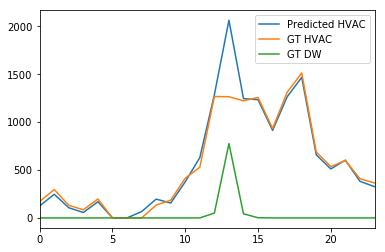

In [359]:
pred_overall_appliance = (maxs[appliance_num]*autoencoder.predict(t_all[30:, 0, :, :].reshape(-1, num_days, num_hours,1)/maxs[0])).reshape(-1,14,24)
ax = pd.DataFrame(pred_overall_appliance[1, 3, :]).squeeze().plot(label='Predicted HVAC')
pd.DataFrame(gt[1, 3, :]).squeeze().plot(ax=ax,label="GT HVAC")
pd.DataFrame(t_all[31,4, 3, :]).squeeze().plot(ax=ax,label="GT DW")
plt.legend()
plt.savefig("/Users/nipun/Desktop/hvac-dw-cnn.png")

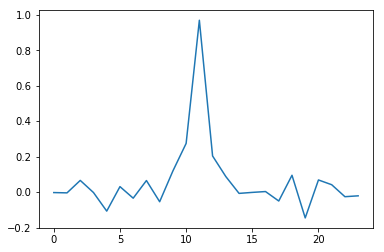

In [266]:
plt.plot(autoencoder.layers[2].get_weights()[0].flatten())

In [10]:
train_agg = t_all[:30, 0, :].reshape(30*14, 24)
train_appliance = {}
test_appliance = {}
for appliance_num, appliance in enumerate(APPLIANCES_ORDER[1:]):
    train_appliance[appliance] = t_all[:30, appliance_num+1, :].reshape(30*14, 24)
    test_appliance[appliance] = t_all[30:, appliance_num+1, :].reshape(22*14, 24)






test_hvac = t_all[30:, 1, :].reshape(22*14, 24)
test_fridge = t_all[30:, 2, :].reshape(22*14, 24)

test_mw = t_all[30:, 3, :].reshape(22*14, 24)



test_agg = t_all[30:, 0, :].reshape(22*14, 24)

In [11]:
train_hvac.shape

NameError: name 'train_hvac' is not defined

In [12]:
train_hvac_fridge = np.hstack([train_hvac, train_fridge])
test_hvac_fridge = np.hstack([test_hvac, test_fridge])

NameError: name 'train_hvac' is not defined

In [80]:
#pred_appliance = {}
sequence_length=24
num_iterations_dictionary = {'hvac':400,'fridge':500,'mw':250,'dw':250,'oven':250, 'wm':300}
for appliance in APPLIANCES_ORDER[2:]:


    print(appliance)
    print("*"*20)
    np.random.seed(0)
    from keras.layers.merge import Subtract, Minimum
    model = Sequential()
    filters=20
    kernel_size=2
    model.add(InputLayer(input_shape=(sequence_length,1)))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='same',
                     activation='relu',
                     strides=1 ,name='C1'))
    model.add(MaxPooling1D(pool_size=2))


    model.add(Dropout(rate=0.1))
    model.add(Conv1D(filters=20,
                     kernel_size=5,
                     padding='same',
                     activation='relu',
                     strides=1 ))
    model.add(MaxPooling1D(pool_size=2))



    model.add(Dropout(rate=0.1))

    model.add(Conv1D(filters=25,
                     kernel_size=3,
                     padding='same',
                     activation='relu',
                     strides=1 ))
    model.add(MaxPooling1D(pool_size=2))


    model.add(Dropout(rate=0.1))

    model.add(Conv1D(filters=30,
                     kernel_size=2,
                     padding='same',
                     activation='relu',
                     strides=1 ))
    model.add(MaxPooling1D(pool_size=2))



    model.add(Dropout(rate=0.1))

    model.add(Flatten())
    model.add(Activation('relu'))

    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(sequence_length, activation='relu'))
    model.add(Dropout(rate=0.1))


    model.compile('adam','mean_absolute_error')
    model.fit(train_agg.reshape(-1, 24, 1), train_appliance[appliance], epochs=num_iterations_dictionary[appliance], validation_split=0.1)
    pred_appliance[appliance] = model.predict(test_agg.reshape(-1,24,1))



fridge
********************
Train on 378 samples, validate on 42 samples
Epoch 1/500
378/378 [==============================] - 1s 3ms/step - loss: 104.0335 - val_loss: 80.1024
Epoch 2/500
378/378 [==============================] - 0s 128us/step - loss: 73.5439 - val_loss: 82.9650
Epoch 3/500
378/378 [==============================] - 0s 120us/step - loss: 69.5276 - val_loss: 71.1884
Epoch 4/500
378/378 [==============================] - 0s 124us/step - loss: 65.7872 - val_loss: 66.9487
Epoch 5/500
378/378 [==============================] - 0s 123us/step - loss: 61.5952 - val_loss: 60.5597
Epoch 6/500
378/378 [==============================] - 0s 121us/step - loss: 57.9371 - val_loss: 58.2805
Epoch 7/500
378/378 [==============================] - 0s 123us/step - loss: 54.5536 - val_loss: 53.5956
Epoch 8/500
378/378 [==============================] - 0s 116us/step - loss: 52.0083 - val_loss: 48.1487
Epoch 9/500
378/378 [==============================] - 0s 110us/step - loss: 49.8050 - v

Epoch 154/500
378/378 [==============================] - 0s 112us/step - loss: 36.6051 - val_loss: 40.9227
Epoch 155/500
378/378 [==============================] - 0s 114us/step - loss: 36.8613 - val_loss: 37.9792
Epoch 156/500
378/378 [==============================] - 0s 118us/step - loss: 36.0987 - val_loss: 39.7679
Epoch 157/500
378/378 [==============================] - 0s 114us/step - loss: 35.8294 - val_loss: 40.1168
Epoch 158/500
378/378 [==============================] - 0s 112us/step - loss: 35.9135 - val_loss: 40.3052
Epoch 159/500
378/378 [==============================] - 0s 113us/step - loss: 35.9357 - val_loss: 41.5186
Epoch 160/500
378/378 [==============================] - 0s 116us/step - loss: 36.4006 - val_loss: 42.6061
Epoch 161/500
378/378 [==============================] - 0s 112us/step - loss: 36.0867 - val_loss: 39.4884
Epoch 162/500
378/378 [==============================] - 0s 120us/step - loss: 36.2109 - val_loss: 40.9371
Epoch 163/500
378/378 [==============

378/378 [==============================] - 0s 112us/step - loss: 31.1762 - val_loss: 39.1932
Epoch 307/500
378/378 [==============================] - 0s 124us/step - loss: 31.3601 - val_loss: 40.4758
Epoch 308/500
378/378 [==============================] - 0s 116us/step - loss: 30.9723 - val_loss: 39.7988
Epoch 309/500
378/378 [==============================] - 0s 115us/step - loss: 31.2240 - val_loss: 39.2697
Epoch 310/500
378/378 [==============================] - 0s 115us/step - loss: 31.3497 - val_loss: 39.5279
Epoch 311/500
378/378 [==============================] - 0s 122us/step - loss: 31.1582 - val_loss: 39.6884
Epoch 312/500
378/378 [==============================] - 0s 117us/step - loss: 31.5861 - val_loss: 40.0486
Epoch 313/500
378/378 [==============================] - 0s 113us/step - loss: 31.2570 - val_loss: 38.6425
Epoch 314/500
378/378 [==============================] - 0s 114us/step - loss: 31.3038 - val_loss: 40.4669
Epoch 315/500
378/378 [============================

378/378 [==============================] - 0s 117us/step - loss: 30.3796 - val_loss: 40.3136
Epoch 459/500
378/378 [==============================] - 0s 113us/step - loss: 30.4188 - val_loss: 39.4738
Epoch 460/500
378/378 [==============================] - 0s 134us/step - loss: 30.3670 - val_loss: 41.0653
Epoch 461/500
378/378 [==============================] - 0s 139us/step - loss: 31.0115 - val_loss: 40.8251
Epoch 462/500
378/378 [==============================] - 0s 148us/step - loss: 29.9184 - val_loss: 39.8697
Epoch 463/500
378/378 [==============================] - 0s 142us/step - loss: 30.1677 - val_loss: 40.4435
Epoch 464/500
378/378 [==============================] - 0s 109us/step - loss: 30.2846 - val_loss: 39.8982
Epoch 465/500
378/378 [==============================] - 0s 118us/step - loss: 30.1463 - val_loss: 40.1937
Epoch 466/500
378/378 [==============================] - 0s 122us/step - loss: 30.7215 - val_loss: 39.5725
Epoch 467/500
378/378 [============================

378/378 [==============================] - 0s 121us/step - loss: 6.3622 - val_loss: 8.3305
Epoch 36/250
378/378 [==============================] - 0s 114us/step - loss: 6.3444 - val_loss: 8.3305
Epoch 37/250
378/378 [==============================] - 0s 118us/step - loss: 6.3139 - val_loss: 8.3305
Epoch 38/250
378/378 [==============================] - 0s 116us/step - loss: 6.3362 - val_loss: 8.3305
Epoch 39/250
378/378 [==============================] - 0s 125us/step - loss: 6.3247 - val_loss: 8.3305
Epoch 40/250
378/378 [==============================] - 0s 116us/step - loss: 6.3242 - val_loss: 8.3305
Epoch 41/250
378/378 [==============================] - 0s 118us/step - loss: 6.3202 - val_loss: 8.3305
Epoch 42/250
378/378 [==============================] - 0s 117us/step - loss: 6.3161 - val_loss: 8.3305
Epoch 43/250
378/378 [==============================] - 0s 116us/step - loss: 6.3093 - val_loss: 8.3305
Epoch 44/250
378/378 [==============================] - 0s 121us/step - loss:

Epoch 114/250
378/378 [==============================] - 0s 117us/step - loss: 6.3000 - val_loss: 8.3305
Epoch 115/250
378/378 [==============================] - 0s 111us/step - loss: 6.3026 - val_loss: 8.3305
Epoch 116/250
378/378 [==============================] - 0s 113us/step - loss: 6.3038 - val_loss: 8.3305
Epoch 117/250
378/378 [==============================] - 0s 119us/step - loss: 6.3012 - val_loss: 8.3305
Epoch 118/250
378/378 [==============================] - 0s 123us/step - loss: 6.3026 - val_loss: 8.3305
Epoch 119/250
378/378 [==============================] - 0s 121us/step - loss: 6.3047 - val_loss: 8.3305
Epoch 120/250
378/378 [==============================] - 0s 114us/step - loss: 6.3041 - val_loss: 8.3305
Epoch 121/250
378/378 [==============================] - 0s 114us/step - loss: 6.3017 - val_loss: 8.3305
Epoch 122/250
378/378 [==============================] - 0s 113us/step - loss: 6.3045 - val_loss: 8.3305
Epoch 123/250
378/378 [==============================] 

378/378 [==============================] - 0s 129us/step - loss: 6.3026 - val_loss: 8.3305
Epoch 193/250
378/378 [==============================] - 0s 115us/step - loss: 6.3012 - val_loss: 8.3305
Epoch 194/250
378/378 [==============================] - 0s 115us/step - loss: 6.3023 - val_loss: 8.3305
Epoch 195/250
378/378 [==============================] - 0s 116us/step - loss: 6.3012 - val_loss: 8.3305
Epoch 196/250
378/378 [==============================] - 0s 115us/step - loss: 6.2995 - val_loss: 8.3305
Epoch 197/250
378/378 [==============================] - 0s 117us/step - loss: 6.3016 - val_loss: 8.3305
Epoch 198/250
378/378 [==============================] - 0s 125us/step - loss: 6.3012 - val_loss: 8.3305
Epoch 199/250
378/378 [==============================] - 0s 119us/step - loss: 6.3012 - val_loss: 8.3305
Epoch 200/250
378/378 [==============================] - 0s 116us/step - loss: 6.3010 - val_loss: 8.3305
Epoch 201/250
378/378 [==============================] - 0s 124us/ste

378/378 [==============================] - 0s 126us/step - loss: 13.4612 - val_loss: 15.0648
Epoch 97/250
378/378 [==============================] - 0s 118us/step - loss: 13.4559 - val_loss: 15.0648
Epoch 98/250
378/378 [==============================] - 0s 129us/step - loss: 13.4462 - val_loss: 15.0648
Epoch 99/250
378/378 [==============================] - 0s 121us/step - loss: 13.4459 - val_loss: 15.0648
Epoch 100/250
378/378 [==============================] - 0s 124us/step - loss: 13.4473 - val_loss: 15.0648
Epoch 101/250
378/378 [==============================] - 0s 125us/step - loss: 13.4471 - val_loss: 15.0648
Epoch 102/250
378/378 [==============================] - 0s 124us/step - loss: 13.4526 - val_loss: 15.0648
Epoch 103/250
378/378 [==============================] - 0s 124us/step - loss: 13.4521 - val_loss: 15.0648
Epoch 104/250
378/378 [==============================] - 0s 129us/step - loss: 13.4508 - val_loss: 15.0648
Epoch 105/250
378/378 [==============================]

378/378 [==============================] - 0s 128us/step - loss: 13.4452 - val_loss: 15.0648
Epoch 249/250
378/378 [==============================] - 0s 120us/step - loss: 13.4452 - val_loss: 15.0648
Epoch 250/250
378/378 [==============================] - 0s 113us/step - loss: 13.4452 - val_loss: 15.0648
wm
********************
Train on 378 samples, validate on 42 samples
Epoch 1/300
378/378 [==============================] - 1s 3ms/step - loss: 83.1399 - val_loss: 17.0875
Epoch 2/300
378/378 [==============================] - 0s 129us/step - loss: 15.5730 - val_loss: 5.7701
Epoch 3/300
378/378 [==============================] - 0s 125us/step - loss: 7.4662 - val_loss: 4.5463
Epoch 4/300
378/378 [==============================] - 0s 128us/step - loss: 6.1663 - val_loss: 4.3702
Epoch 5/300
378/378 [==============================] - 0s 128us/step - loss: 5.5833 - val_loss: 4.3453
Epoch 6/300
378/378 [==============================] - 0s 124us/step - loss: 5.3496 - val_loss: 4.3410
Epoch

378/378 [==============================] - 0s 119us/step - loss: 4.7265 - val_loss: 4.3410
Epoch 155/300
378/378 [==============================] - 0s 127us/step - loss: 4.7330 - val_loss: 4.3410
Epoch 156/300
378/378 [==============================] - 0s 117us/step - loss: 4.7379 - val_loss: 4.3410
Epoch 157/300
378/378 [==============================] - 0s 130us/step - loss: 4.7319 - val_loss: 4.3410
Epoch 158/300
378/378 [==============================] - 0s 128us/step - loss: 4.7332 - val_loss: 4.3410
Epoch 159/300
378/378 [==============================] - 0s 136us/step - loss: 4.7318 - val_loss: 4.3410
Epoch 160/300
378/378 [==============================] - 0s 129us/step - loss: 4.7411 - val_loss: 4.3410
Epoch 161/300
378/378 [==============================] - 0s 122us/step - loss: 4.7391 - val_loss: 4.3410
Epoch 162/300
378/378 [==============================] - 0s 119us/step - loss: 4.7347 - val_loss: 4.3410
Epoch 163/300
378/378 [==============================] - 0s 126us/ste

378/378 [==============================] - 0s 134us/step - loss: 14.6388 - val_loss: 13.5292
Epoch 10/250
378/378 [==============================] - 0s 125us/step - loss: 14.5970 - val_loss: 13.5281
Epoch 11/250
378/378 [==============================] - 0s 134us/step - loss: 14.5895 - val_loss: 13.5295
Epoch 12/250
378/378 [==============================] - 0s 124us/step - loss: 14.5554 - val_loss: 13.5289
Epoch 13/250
378/378 [==============================] - 0s 133us/step - loss: 14.5966 - val_loss: 13.5239
Epoch 14/250
378/378 [==============================] - 0s 135us/step - loss: 14.5681 - val_loss: 13.5176
Epoch 15/250
378/378 [==============================] - 0s 133us/step - loss: 14.5617 - val_loss: 13.5187
Epoch 16/250
378/378 [==============================] - 0s 124us/step - loss: 14.5268 - val_loss: 13.5165
Epoch 17/250
378/378 [==============================] - 0s 123us/step - loss: 14.5224 - val_loss: 13.5165
Epoch 18/250
378/378 [==============================] - 0s 

Epoch 86/250
378/378 [==============================] - 0s 121us/step - loss: 14.4617 - val_loss: 13.5180
Epoch 87/250
378/378 [==============================] - 0s 134us/step - loss: 14.4544 - val_loss: 13.5179
Epoch 88/250
378/378 [==============================] - 0s 122us/step - loss: 14.4448 - val_loss: 13.5183
Epoch 89/250
378/378 [==============================] - 0s 129us/step - loss: 14.4630 - val_loss: 13.5165
Epoch 90/250
378/378 [==============================] - 0s 132us/step - loss: 14.4542 - val_loss: 13.5165
Epoch 91/250
378/378 [==============================] - 0s 131us/step - loss: 14.4567 - val_loss: 13.5181
Epoch 92/250
378/378 [==============================] - 0s 134us/step - loss: 14.4473 - val_loss: 13.5075
Epoch 93/250
378/378 [==============================] - 0s 121us/step - loss: 14.4660 - val_loss: 13.5007
Epoch 94/250
378/378 [==============================] - 0s 132us/step - loss: 14.4361 - val_loss: 13.5165
Epoch 95/250
378/378 [========================

378/378 [==============================] - 0s 131us/step - loss: 12.7644 - val_loss: 12.3515
Epoch 239/250
378/378 [==============================] - 0s 133us/step - loss: 12.8034 - val_loss: 12.4435
Epoch 240/250
378/378 [==============================] - 0s 119us/step - loss: 12.6870 - val_loss: 12.4177
Epoch 241/250
378/378 [==============================] - 0s 128us/step - loss: 12.7014 - val_loss: 12.5220
Epoch 242/250
378/378 [==============================] - 0s 132us/step - loss: 12.6575 - val_loss: 12.5753
Epoch 243/250
378/378 [==============================] - 0s 122us/step - loss: 12.7996 - val_loss: 12.5444
Epoch 244/250
378/378 [==============================] - ETA: 0s - loss: 10.83 - 0s 128us/step - loss: 12.7116 - val_loss: 12.3564
Epoch 245/250
378/378 [==============================] - 0s 137us/step - loss: 12.6985 - val_loss: 12.5121
Epoch 246/250
378/378 [==============================] - 0s 130us/step - loss: 12.6630 - val_loss: 12.5820
Epoch 247/250
378/378 [====

In [25]:
with open('per-appliance.pdf','wb') as f:
    f.write(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='pdf'))



In [63]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 24, 1)             0         
_________________________________________________________________
C1 (Conv1D)                  (None, 24, 20)            220       
_________________________________________________________________
max_pooling1d_41 (MaxPooling (None, 12, 20)            0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 12, 20)            0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 12, 20)            2020      
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 6, 20)             0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 6, 20)             0         
__________

In [81]:
from sklearn.metrics import mean_absolute_error
mae = {}
for appliance in APPLIANCES_ORDER[1:]:
    try:
        mae[appliance] = mean_absolute_error(test_appliance[appliance], pred_appliance[appliance])
    except Exception as e:
        print(e)
    
    

In [82]:
pd.Series(mae)

dw         14.499116
fridge     34.620154
hvac      331.035001
mw          6.300214
oven       18.633957
wm          5.617521
dtype: float64

In [83]:
pd.Series(mae)

dw         14.499116
fridge     34.620154
hvac      331.035001
mw          6.300214
oven       18.633957
wm          5.617521
dtype: float64

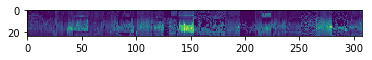

In [84]:
plt.imshow(test_agg.T)

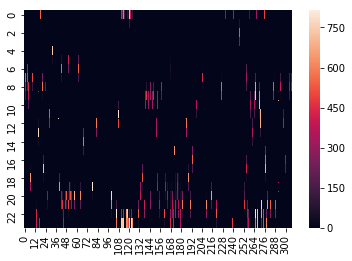

In [85]:
import seaborn as sns
sns.heatmap(test_appliance['dw'].T)

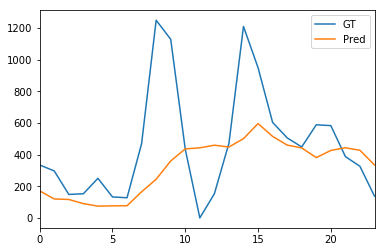

In [93]:
pd.Series(test_appliance['hvac'][14]).plot(label='GT')

pd.Series(pred_appliance['hvac'][14]).plot(label='Pred')
plt.legend()

In [2]:
pred_hvac = model.predict(test_agg)


from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(pred_hvac, test_fridge))
print(mean_absolute_error(pred_hvac, test_agg))




NameError: name 'model' is not defined

In [282]:
(pd.DataFrame(pred_hvac) - pd.DataFrame(test_agg)).max()

0     1.907349e-06
1    -3.877686e+00
2    -9.150000e+00
3     0.000000e+00
4     0.000000e+00
5    -9.633333e+00
6     0.000000e+00
7     2.861023e-06
8    -8.683333e+00
9     9.536743e-07
10    0.000000e+00
11    9.536743e-07
12   -9.583333e+00
13   -9.516666e+00
14   -4.711666e+01
15    3.099442e-06
16   -4.685000e+01
17    9.536743e-07
18   -7.310000e+01
19   -7.350000e+01
20   -4.180000e+01
21    0.000000e+00
22   -9.616667e+00
23   -9.533334e+00
dtype: float64

In [1]:
pd.Series(test_mw[1, :]).plot(label='GT')
#pd.Series(test_agg[1, :]).plot(label='GT')


pd.Series(model.predict(test_agg[1:2])[0, :24]).plot(label='Pred')




plt.legend()

NameError: name 'pd' is not defined